# C4dynamics

## 6 Degrees Of Freedom Example 

This notebook employs an example to illustrate the usage of C4dynamics to develop algorithms for missile guidance system. 

C4dynamics is a powerful framework for algorithm engineering that enables the creation of complex simulations with six degrees of freedom (6 DOF). With its advanced toolset, it allows for the creation of realistic and dynamic models that can be used to test and analyze various scenarios in fields such as robotics, aerospace, and mechanical engineering.

A 6 DOF simulation on top C4dynamics provides a comprehensive platform for exploring the movement and behavior of objects in 3D space. It includes features such as real-time rendering, physics simulation, and user interaction, allowing for a highly immersive and interactive experience. The simulation is built on top of the C4dynamics framework, which provides a robust and scalable infrastructure for developing and running algorithms.

In this demonstration, we will showcase the power and flexibility of C4dynamics by creating a 6 DOF simulation that demonstrates its ability to accurately model complex systems and provide real-time feedback. This will include an overview of the features and tools available in C4dynamics, as well as a hands-on demonstration of how to create and run a 6 DOF simulation. Whether you are a seasoned engineer or just starting out, this demonstration will provide valuable insights into the capabilities of the C4dynamics framework.



So, let's start: 

Load third party modules 

In [6]:
import sys, os
import numpy as np
from matplotlib import pyplot as plt

Load C4dynamics

Add the module to python path

In [7]:
sys.path.append(os.path.join(os.getcwd(), '..', '..'))

Load the module

In [8]:
import c4dynamics as c4d

Load other modules that developed for the demonstration of current example 

In [9]:
import control_system as mcontrol_system 
import engine as mengine 
import aerodynamics as maerodynamics

Configure figure properties 

In [11]:
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

Simulation setup

In [12]:
t   = 0
dt  = 5e-3
tf  = 10 

Objects definition 

In [13]:
target = c4d.datapoint(x = 4000, y = 1000, z = -3000
                        , vx = -250, vy = 0, vz = 0)


The target is a datapoint object which means it has all the attributes of a mass in space:
Position: target.x, target.y, target.z
Velocity: target.vx, target.vy, target.vz
Acceleration: target.ax, target.ay, target.az
It also has mass: target.m (necessary for solving the equations of motion in the case of accelerating motion)

The target object in the example is initialized with initial position conditions in 3 axes and velocity conditions in the x-axis only. Acceleration is not initialized which is equivalent to zero initialization (default).
As the target in the example is non-accelerating it is not necessary to provide the mass with its instantiation.

In [14]:
missile = c4d.rigidbody(m = 85, iyy = 61, izz = 61, xcm = 1.55)

m0      = missile.m
xcm0    = missile.xcm
i0      = missile.iyy

The missile is a rigid-body object which means that it has all the attributes of a datapoint but in addition:
Body angles: missile.phi, missile.theta, missile.psi (Euler)
Angular rates: missile.p, missile.q, missile.r (rotation about x-body, y-body, and z-body, respectively)
Angular accelerations: missile.p_dot, missile.q_dot, missile.r_dot (about x-body, y-body, and z-body, respectively)

As a rigid-body object it has also inertia attributes (necessary for solving the equations of motion in the case of accelerating motion):
Moment of inertia: missile.ixx, missile.iyy, missile.izz (about x-body, y-body, and z-body, respectively)
Distance from nose to center of mass: missile.xcm

The missile kinematic attributes in this example have not initialized with any initial conditions which mean that all its attributes are zero. But the mass properties provided as necessary. 
However, we will immediately see that the missile has initial kinematic conditions which are loaded through direct assignment and not by the class constructor (c4d.rigidbody()).

As the dynamics in this example involves a combustion of fuel of the rocket engine the missile’s mass attributes varying as function of time. To recalculate the mass during the run time it's a good advice to save these initial conditions. As iyy and izz are equal here it's enough to save just one of them.
In any way the initial position and attitude of anybody object (datapoint and rigid-body) is always saved with its instantiation 

The dimensions in this example are SI (i.e. seconds, meters, kilograms), but the objects and functions in the framework in general are independent of system of units. 

The example uses a line-of-sight seeker object from the c4dynamics' seekers module and controller, engine, and aerodynamics objects that developed for the purpose of this example:

In [15]:
seeker  = c4d.seekers.lineofsight(dt, tau1 = 0.01, tau2 = 0.01)
ctrl    = mcontrol_system.control_system(dt)
eng     = mengine.engine()
aero    = maerodynamics.aerodynamics()

User input data:

In [16]:
# 
# missile total initial velocity 
##
vm          = 30        

# 
# atmospheric properties up to 2000m
##
pressure    = 101325    # pressure pascals
rho         = 1.225     # density kg/m^3
vs          = 340.29    # speed of sound m/s
mach        = 0.8

# 
# combustion properties 
## 
mbo         = 57        # burnout mass, kg 
xcmbo       = 1.35      # nose to cm after burnout, m
ibo         = 47        # iyy izz at burnout 

Preliminary calculations 


The initial missile pointing direction and angular rates are calculated in the fire-control block. 
For the example simulation, a simple algorithm is employed in which the missile is pointed directly at the target at the instant of launch, and missile angular rates at launch are assumed to be negligible.

The unit vector in the direction from the missile to the target is calculated by normalizing the range vector.

In [17]:
rTM             = target.pos() - missile.pos()
ucl             = rTM / np.linalg.norm(rTM)     # center line unit vector 
missile.vx, missile.vy, missile.vz = vm * ucl 
missile.psi     = np.arctan(ucl[1] / ucl[0])
missile.theta   = np.arctan(-ucl[2] / np.sqrt(ucl[0]**2 + ucl[1]**2))
missile.phi     = 0
alpha           = 0
beta            = 0
alpha_total     = 0
h               = -missile.z

The function missile.BI() is bounded method of the rigid-body class.
The function generates a Body from Inertial DCM (Direction Cosine Matrix) matrix in 3-2-1 order.
Using this matrix, the missile velocity vector in the inertial frame of coordinates is rotated to represent the velocity in the body frame of coordinates.

The inertial frame is determined by the frame that the initial Euler angles refer to.
In this example the Euler angles are with respect the x parallel to flat earth in the direction of the missile centerline, z positive downward, and y such that z completes a right-hand system.

The velocity vector is also produced by a bounded method of the class. The methods datapoint.pos(), datapoint.vel(), datapoint.acc() read the current state of the object and return a three entries array composed of the coordinates of position, velocity, and acceleration, respectively. 

Similarly, the functions datapoint.P(), datapoint.V(), datapoint.A() return the object squared norm of the position, velocity, and acceleration, respectively.

In [18]:
u, v, w = missile.BI() @ missile.vel()

Main loop

The main loop includes the following steps: 

    Estimation of missile-target line-of-sight angular rate 
    Production of missile's wings-deflection commands 
    Calculation of missile's forces and moments 
    Integration of missile's equations of motion 
    Integration of target's equations of motion 
    Simulation update 


The simulation runs until one of the following conditions:
    The missile hits the ground
    The simulation time is over 


Comments are introduced inline.


The missile.run() function and the target.run() function perform integration of the equations of motion. 
The integration is performed by running Runge-Kutta of fourth order. 
For a datapoint, the equations are composed of translational equations, while for a datapoint they also include the rotational equations. 

Therefore, for a datapoint object, like the target in this example, a force vector is necessary for the evaluation of the derivatives. The force must be given in the inertial frame of reference. As the target in this example is not maneuvering, the force vector is [0, 0, 0].

For a rigid-body object, like the missile in this example, a force vector and moment vector are necessary for the evaluation of the derivatives. The force vector must be given in the inertial frame of reference. Therefore, the propulsion, and the aerodynamic forces are rotated to the inertial frame using the DCM321 missile.IB() function. The gravity forces are already given in the inertial frame and therefore remain intact. 

Forces and moments in the inertial frame are introduced to provide an estimation of the derivatives that represent the equations of motion. The integration method, 4th order Runge-Kutta is performed manually and independent on any third-party framework (such as scipy), therefore, currently, they may be non-optimal in terms of step-size variation. 
The choice of this is due to a feature which this framework desires to satisfy in which derivatives of two objects (such as missile and target) could be integrated simultaneously, with reciprocal dependent. 

Hopefully, later the function will be also optimized in terms of run-time and step-size variation.

In [20]:
while t <= tf and h >= 0:

    #
    # atmospheric calculations    
    ##
    mach    = missile.V() / vs                  # mach number 
    Q       = 1 / 2 * rho * missile.V()**2      # dynamic pressure 
    
    # 
    # relative position
    ##
    vTM     = target.vel() - missile.vel()      # missile-target relative velocity 
    rTM     = target.pos() - missile.pos()      # relative position 
    uR      = rTM / np.linalg.norm(rTM)         # unit range vector 
    vc      = -uR * vTM                         # closing velocity 

    # 
    # seeker 
    ## 
    wf      = seeker.measure(rTM, vTM)          # filtered los vector 
    
    # 
    # guidance and control 
    ##
    Gs          = 4 * missile.V()               # guidance gain
    acmd        = Gs * np.cross(wf, ucl)        # acceleration command
    ab_cmd      = missile.BI() @ acmd           # acc. command in body frame 
    afp, afy    = ctrl.update(ab_cmd, Q)        # acchived pithc, yaw fins deflections 
    d_pitch     = afp - alpha                   # effecive pitch deflection
    d_yaw       = afy - beta                    # effective yaw deflection 


    # 
    # missile dynamics 
    ##
    
    #
    # aerodynamics forces 
    ##    
    cL, cD      = aero.f_coef(alpha_total)
    L           = Q * aero.s * cL
    D           = Q * aero.s * cD
    
    A           = D * np.cos(alpha_total) - L * np.sin(alpha_total) # aero axial force 
    N           = D * np.sin(alpha_total) + L * np.cos(alpha_total) # aero normal force 
    
    fAb         = np.array([ -A
                            , N * (-v / np.sqrt(v**2 + w**2))
                            , N * (-w / np.sqrt(v**2 + w**2))])
    fAe         = missile.IB() @ fAb
   
    # 
    # aerodynamics moments 
    ##
    cM, cN      = aero.m_coef(alpha, beta, d_pitch, d_yaw 
                            , missile.xcm, Q, missile.V(), fAb[1], fAb[2]
                            , missile.q, missile.r)
    
    mA          = np.array([0                               # aerodynamic moemnt in roll
                            , Q * cM * aero.s * aero.d         # aerodynamic moment in pitch
                            , Q * cN * aero.s * aero.d])       # aerodynamic moment in yaw 

    # 
    # propulsion 
    ##
    thrust, thref = eng.update(t, pressure)
    fPb         = np.array([thrust, 0, 0]) 
    fPe         = missile.IB() @ fPb

    # 
    # gravity
    ## 
    fGe         = np.array([0, 0, missile.m * c4d.params.g])

    # 
    # total forces
    ##      
    forces      = np.array([fAe[0] + fPe[0] + fGe[0]
                            , fAe[1] + fPe[1] + fGe[1]
                            , fAe[2] + fPe[2] + fGe[2]])
    
    # 
    # missile motion integration
    ##
    missile.run(dt, forces, mA)
    u, v, w     = missile.BI() @ np.array([missile.vx, missile.vy, missile.vz])
    
    
    # 
    # target dynmaics 
    ##
    target.run(dt, np.array([0, 0, 0]))


    # 
    # update  
    ##
    t += dt
    missile.store(t)
    target.store(t)

    
    missile.m      -= thref * dt / eng.Isp        
    missile.xcm     = xcm0 - (xcm0 - xcmbo) * (m0 - missile.m) / (m0 - mbo)
    missile.izz     = missile.iyy = i0 - (i0 - ibo) * (m0 - missile.m) / (m0 - mbo)

    alpha           = np.arctan2(w, u)
    beta            = np.arctan2(-v, u)
    
    uvm             = missile.vel() / missile.V()
    ucl             = np.array([np.cos(missile.theta) * np.cos(missile.psi)
                                , np.cos(missile.theta) * np.sin(missile.psi)
                                , np.sin(-missile.theta)])
    alpha_total = np.arccos(uvm @ ucl)
    
    h = -missile.z   
    


about the datasave 

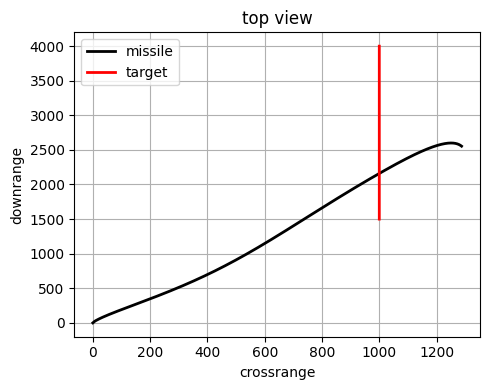

In [21]:
fig = plt.figure()
plt.plot(missile._data[1:, 2], missile._data[1:, 1], 'k', linewidth = 2, label = 'missile')
plt.plot(target._data[1:, 2], target._data[1:, 1], 'r', linewidth = 2, label = 'target')
plt.title('top view')
plt.xlabel('crossrange')
plt.ylabel('downrange')
plt.grid()
plt.legend()
fig.tight_layout()
plt.show()


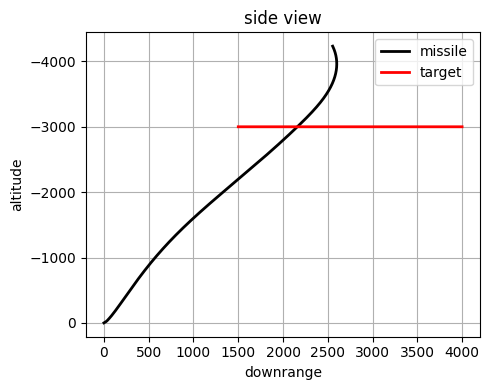

In [22]:

fig = plt.figure()
plt.plot(missile._data[1:, 1], missile._data[1:, 3], 'k', linewidth = 2, label = 'missile')
plt.plot(target._data[1:, 1], target._data[1:, 3], 'r', linewidth = 2, label = 'target')
plt.title('side view')
plt.xlabel('downrange')
plt.ylabel('altitude')
plt.gca().invert_yaxis()
plt.grid()
plt.legend()
fig.tight_layout()
plt.show()


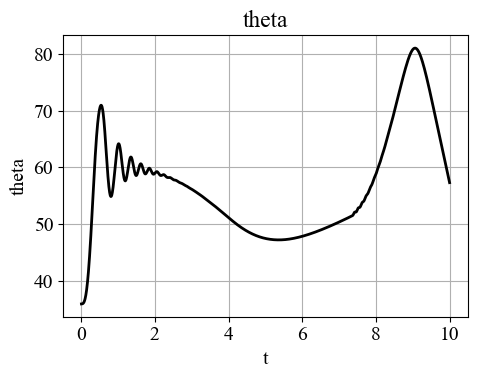

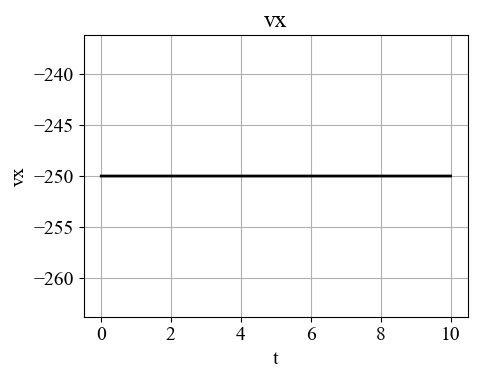

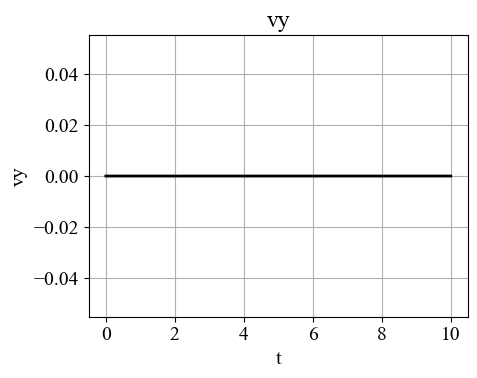

In [23]:
missile.draw('theta')

target.draw('vx')
target.draw('vy')
